In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path
from skimage import io
from skimage.util import img_as_ubyte

In [2]:
root_dir = Path().cwd().parent
interim_dir = root_dir / 'data/interim'
undistorted_dir = interim_dir / 'undistorted'
rectified_dir = interim_dir / 'rectified'
rectified_dir.mkdir(parents=True, exist_ok=True)

In [60]:
def drawlines(img1,lines,pts1):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    for r,pt1 in zip(lines,pts1):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,2)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
    return img1

In [99]:
def rectifyImages(img1, img2, nb_matches=500):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    bf = cv2.BFMatcher()
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)

   
    good = []
    pts1 = []
    pts2 = []
    for m in matches[:nb_matches]:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)#, ransacReprojThreshold=1, confidence=0.95)
    pts1 = pts1[mask.ravel() == 1]
    pts2 = pts2[mask.ravel() == 1]
    good2 = []
    for i in range(len(mask)):
        if mask[i]: good2.append(good[i])
    
    Feature_matching = cv2.drawMatches(img1,kp1,img2,kp2,good2,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    #### EPIPOLAR
    # Find epilines corresponding to points in right image (second image) and
    # drawing its lines on left image
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
    lines1 = lines1.reshape(-1, 3)
    left_with_lines = drawlines(img1, lines1, pts1)
    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
    lines2 = lines2.reshape(-1, 3)
    right_with_lines = drawlines(img2, lines2, pts2)


    ret, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(pts1), np.float32(pts2), F, imgSize=img1.shape)
    if ret:
        img1_rect = cv2.warpPerspective(img1, H1, (img1.shape[1], img1.shape[0]))
        img2_rect = cv2.warpPerspective(img2, H2, (img2.shape[1], img2.shape[0]))

        

        return img1_rect, img2_rect, left_with_lines, right_with_lines, Feature_matching
    else:
        return None, None

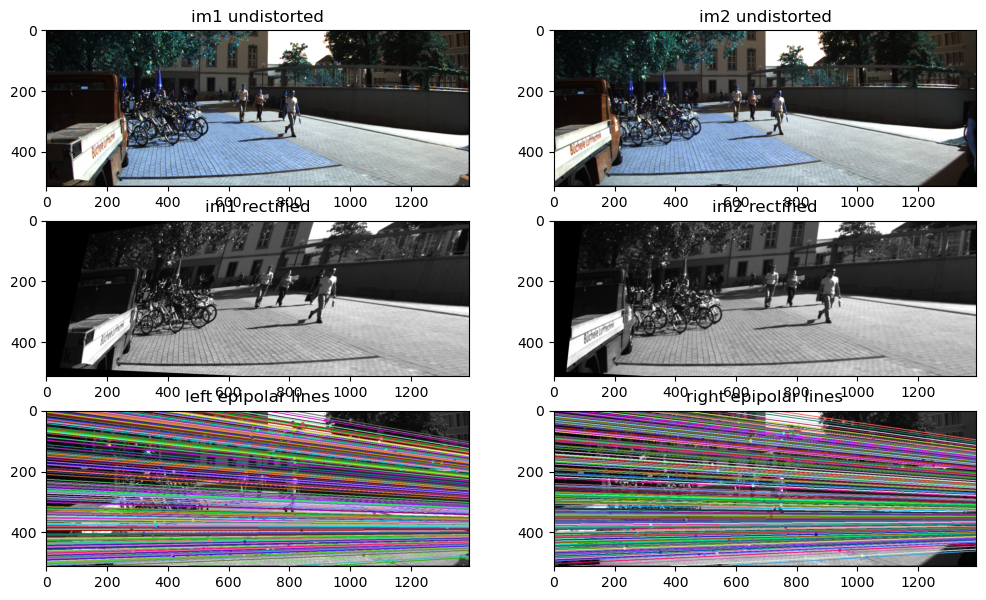

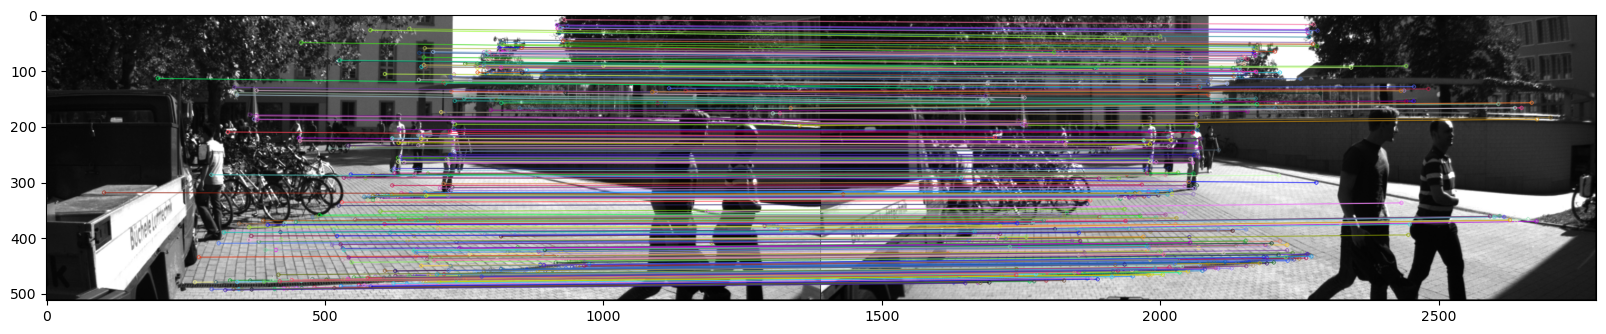

In [100]:
# folders = os.listdir(undistorted_dir)
# images = os.listdir(undistorted_dir / folders[0])
# for k, image in enumerate(images):
#     im1 = io.imread(undistorted_dir / folders[0] / image)
#     im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
#     im2 = io.imread(undistorted_dir / folders[1] / image)
#     im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

#     im1_rect, im2_rect = rectifyImages(im1_gray, im2_gray)

#     if (k == 0):
#         fig, axs = plt.subplots(2, 2, figsize=(10,10))
#         axs[0, 0].imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
#         axs[0, 0].set_title('im1 undistorted')
#         axs[0, 1].imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
#         axs[0, 1].set_title('im2 undistorted')
#         axs[1, 0].imshow(cv2.cvtColor(im1_rect, cv2.COLOR_GRAY2RGB))
#         axs[1, 0].set_title('im1 rectified')
#         axs[1, 1].imshow(cv2.cvtColor(im2_rect, cv2.COLOR_GRAY2RGB))
#         axs[1, 1].set_title('im2 rectified')

folders = os.listdir(root_dir / 'data/raw/final_project/seq_01')
images = os.listdir(root_dir / 'data/raw/final_project/seq_01' / folders[0] / 'data')[:10]

for k, image in enumerate(images):
    im1 = io.imread(root_dir / 'data/raw/final_project/seq_01' / folders[0] / 'data' / image)
    im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2 = io.imread(root_dir / 'data/raw/final_project/seq_01' / folders[1] / 'data' / image)
    im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    im1_rect, im2_rect, epi1, epi2, feature_match= rectifyImages(im1_gray, im2_gray)

    if (k == 0):
        fig, axs = plt.subplots(3, 2, figsize=(12,7))
        axs[0, 0].imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
        axs[0, 0].set_title('im1 undistorted')
        axs[0, 1].imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
        axs[0, 1].set_title('im2 undistorted')
        axs[1, 0].imshow(cv2.cvtColor(im1_rect, cv2.COLOR_GRAY2RGB))
        axs[1, 0].set_title('im1 rectified')
        axs[1, 1].imshow(cv2.cvtColor(im2_rect, cv2.COLOR_GRAY2RGB))
        axs[1, 1].set_title('im2 rectified')
        axs[2, 0].imshow(epi1)
        axs[2, 0].set_title('left epipolar lines')
        axs[2, 1].imshow(epi2)
        axs[2, 1].set_title('right epipolar lines')
        # axs[3, 1].imshow(feature_match)
        # axs[3, 1].set_title('feature matching')

plt.figure(figsize = (20,20))
plt.imshow(feature_match)